<a href="https://colab.research.google.com/github/swtguha/Sentiment_Analysis-of-IMDB_Review/blob/main/IMDBMovie_Review_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/IMDB Dataset.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
pip install pandas numpy tensorflow scikit-learn

In [29]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, classification_report

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load the CSV file into a DataFrame
data = pd.read_csv(file_path)
# Assuming the dataset has columns 'review' for text and 'sentiment' for labels
texts = data['review'].values
labels = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Check the data type of the 'review' column
print("Data type of 'review' column:", data['review'].dtype)

Data type of 'review' column: object


In [31]:
# Check for missing values
missing_values = data['review'].isnull().sum()
print(f"Number of missing values in 'review' column: {missing_values}")

# Optionally, print out some of the missing entries (if any)
print(data[data['review'].isnull()].head())

Number of missing values in 'review' column: 0
Empty DataFrame
Columns: [review, sentiment]
Index: []


In [32]:
# Check for missing values and handle them
print("Missing values before cleaning:\n", data.isnull().sum())

Missing values before cleaning:
 review       0
sentiment    0
dtype: int64


In [33]:
# Preprocess Text Data
# Example text preprocessing function
def preprocess_text(text):
    """

    Args:
      text:

    Returns:

    """
    stop_words = set(stopwords.words('english'))
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return ' '.join(tokens)  # Reconstruct text
data['review'] = data['review'].apply(preprocess_text)  # Apply preprocessing

In [34]:
# Convert Sentiment Labels
labels = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

In [55]:
data['sentiment'].replace(to_replace='positive', value=1, inplace=True)
data['sentiment'].replace(to_replace='negative',  value=0, inplace=True)

In [56]:
from sklearn.model_selection import train_test_split

# Splitting the data
X = data.drop('sentiment', axis=1)
y = data['sentiment']

# First split the data into training (60%) and temporary (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Then split the temporary set into validation (20%) and testing (20%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [68]:
print(X_train.shape)

(30000, 1)


In [83]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train['review'])
#print(tokenizer.index_word)

X_train_sequences = tokenizer.texts_to_sequences(X_train['review'])
X_val_sequences = tokenizer.texts_to_sequences(X_val['review'])
X_test_sequences = tokenizer.texts_to_sequences(X_test['review'])


#print(X_train_sequences)


In [85]:
# Pad sequences to ensure equal length
X_train_padded = pad_sequences(X_train_sequences, maxlen=200)  # Adjust maxlen as needed
X_val_padded = pad_sequences(X_val_sequences, maxlen=200)
X_test_padded = pad_sequences(X_test_sequences, maxlen=200)
print(X_train_padded)

[[   0    0    0 ...  108  104  185]
 [   0    0    0 ...   29  146  160]
 [   0    0    0 ...    2  273 6293]
 ...
 [   0    0    0 ... 1004 1477  519]
 [   0    0    0 ...  144   30 7338]
 [   0    0    0 ...  373   13 1797]]


In [86]:
# Ensure target labels are numeric
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [87]:
# Build Model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [88]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
# Train Model
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_data=(X_val_padded, y_val))


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 154s 321ms/step - accuracy: 0.7563 - loss: 0.4638 - val_accuracy: 0.8872 - val_loss: 0.2758
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 211s 342ms/step - accuracy: 0.9208 - loss: 0.2157 - val_accuracy: 0.8840 - val_loss: 0.2942
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 208s 354ms/step - accuracy: 0.9478 - loss: 0.1461 - val_accuracy: 0.8767 - val_loss: 0.3342
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 347ms/step - accuracy: 0.9629 - loss: 0.1067 - val_accuracy: 0.8696 - val_loss: 0.3865
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 343ms/step - accuracy: 0.9776 - loss: 0.0711 - val_accuracy: 0.8657 - val_loss: 0.4233


In [90]:
# Test Model
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step
Test Accuracy: 0.8634
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86      4979
    Positive       0.86      0.87      0.86      5021

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



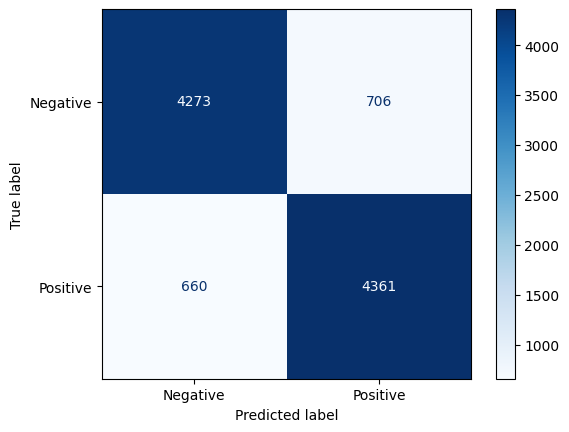

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step


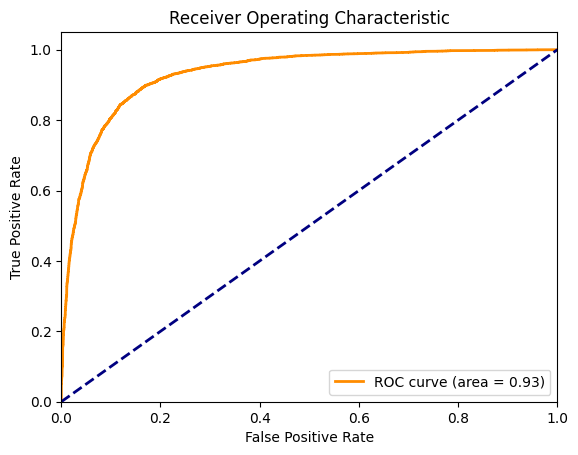

In [93]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test_padded))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()